# Adversarial validation
* I am not sure that the training and validation dataset are representative
* Adversarial validation to test this
    * Assign an ID (0, 1) for train, validation, respectively
    * Lump together, and train a binary classifier
    * Evaluate ROC
* More info: https://www.kaggle.com/code/carlmcbrideellis/what-is-adversarial-validation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use('seaborn')

# Data preparation

In [3]:
data = pd.read_csv('../../data/SamDysch_glucose_2-5-2022.csv', skiprows=[0])
data.index = pd.to_datetime(data['Device Timestamp'], format="%d-%m-%Y %H:%M")

/home/sdysch/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# drop non-historic glucose records
data = data[data['Record Type'] == 0]

# only keep bg
to_keep = [
    'Historic Glucose mmol/L',
]
data = data[to_keep]

data = data.rename(columns={'Historic Glucose mmol/L': 'reading'})

data.head()

,reading
Device Timestamp,
2019-12-09 19:04:00,6.8
2019-12-09 19:20:00,7.6
2019-12-09 19:35:00,7.7
2019-12-09 19:50:00,7.2
2019-12-09 20:05:00,5.8


In [5]:
# drop NaNs
data = data.dropna()

# Setup hypo threshold

In [6]:
HYPO_THRESHOLD = 3.9
data['is_hypo'] = (data['reading'] < HYPO_THRESHOLD).astype(int)

In [7]:
# adding some time variables
data['hour'] = data.index.hour
data['day'] = data.index.dayofweek
data['month'] = data.index.month

# Encode hours

In [8]:
# OneHotEncode
# data = pd.get_dummies(data, prefix='hour', columns=['hour'])

# sin/cosine encode
data['sin_hour'] = np.sin(2 * np.pi * data['hour'] / 23)
data['cos_hour'] = np.cos(2 * np.pi * data['hour'] / 23)
data = data.drop(['hour'], axis='columns')
print(data.columns)

Index(['reading', 'is_hypo', 'day', 'month', 'sin_hour', 'cos_hour'], dtype='object')


# creating a lagged and rolling variables
* Was I hypo 15 mins ago? 30 mins ago? Etc
* Rolling average of last N readings
* Sign of gradient of last N readings:
    * I.e., is BG rising, falling, or stable?
    
## Lagged features

In [9]:
# create lags
# To ensure that we do not make a lag between periods of sensor non-usage, create a new df with the lagged indices & merge onto original data frame
def create_lag(df, lag):
    tolerance = 15 * lag
    freq = '15min'
    print(f'Creating lag of {tolerance} minutes')
    lagged_copy = df[['reading']].shift(lag, freq=freq)
    lagged_copy.rename(columns={'reading': f'lagged_reading_{lag}'}, inplace=True)
    
    merged = pd.merge_asof(df, lagged_copy, left_index=True, right_index=True, direction='backward', tolerance=pd.Timedelta(minutes=tolerance))
    # merged = pd.merge_asof(copy, lagged_copy, left_index=True, right_index=True, direction='backward')
    return merged

NLAGS = 8
for lag in range(1, NLAGS):
    data = create_lag(data, lag)

Creating lag of 15 minutes
Creating lag of 30 minutes
Creating lag of 45 minutes
Creating lag of 60 minutes
Creating lag of 75 minutes
Creating lag of 90 minutes
Creating lag of 105 minutes


In [10]:
# For ease of variable calculation, drop the nans
data = data.dropna()

In [11]:
# lagged hypo bools
for lag in range(1, NLAGS):
    data[f'is_lagged_hypo_{lag}'] = (data[f'lagged_reading_{lag}'] < HYPO_THRESHOLD).astype(int)

## Rolling features

In [12]:
# simple differences of lags - was reading higher, lower, or stable?
for lag in range(2, NLAGS):
    data[f'diff_{lag}'] = data['lagged_reading_1'] - data[f'lagged_reading_{lag}']

# gradients - how quick is BG changing?
interval = 15
for lag in range(2, NLAGS):
    data[f'rate_{lag}'] = data[f'diff_{lag}'] / (interval * lag)

## train, test, validation split

In [13]:
TRAIN_SPLIT = 0.5
VAL_SPLIT = 0.35
TEST_SPLIT = 0.15

In [14]:
itrain = int(TRAIN_SPLIT * len(data))
ival = int(VAL_SPLIT * len(data))
itest = int(TEST_SPLIT * len(data))

train_data = data.iloc[:itrain]
val_data = data.iloc[itrain:itrain + ival]
test_data = data.iloc[itrain + ival:]

# Variable selection

In [15]:
rates_and_diffs = [f'diff_{v}' for v in range(2, NLAGS)]
rates_and_diffs.extend([f'rate_{v}' for v in range(2, NLAGS)])

vars_to_drop = [
    'month',
    'day',
    'reading',
    'is_lagged_hypo_1',
    'is_lagged_hypo_2',
    'lagged_reading_1',
    'lagged_reading_2',
    
    'is_lagged_hypo_3',
    'is_lagged_hypo_4',
    'is_lagged_hypo_5',
    'is_lagged_hypo_6',
    'is_lagged_hypo_7',
    
]
vars_to_drop.extend(rates_and_diffs)

train_data = train_data.drop(vars_to_drop, axis='columns')
val_data = val_data.drop(vars_to_drop, axis='columns')
test_data = test_data.drop(vars_to_drop, axis='columns')

print(train_data.columns)
print(val_data.columns)
print(test_data.columns)

Index(['is_hypo', 'sin_hour', 'cos_hour', 'lagged_reading_3',
       'lagged_reading_4', 'lagged_reading_5', 'lagged_reading_6',
       'lagged_reading_7'],
      dtype='object')
Index(['is_hypo', 'sin_hour', 'cos_hour', 'lagged_reading_3',
       'lagged_reading_4', 'lagged_reading_5', 'lagged_reading_6',
       'lagged_reading_7'],
      dtype='object')
Index(['is_hypo', 'sin_hour', 'cos_hour', 'lagged_reading_3',
       'lagged_reading_4', 'lagged_reading_5', 'lagged_reading_6',
       'lagged_reading_7'],
      dtype='object')


# combine into one super dataset

In [25]:
target = 'is_hypo'
X_train = train_data.drop([target], axis='columns')
X_val = val_data.drop(target, axis='columns')

X_train['target'] = 0
X_val['target'] = 1

combined_data = pd.concat([X_train, X_val], axis=0, ignore_index=True)
combined_data = combined_data.sample(frac=1)
X_combined = combined_data.drop(['target'], axis='columns')
y_combined = combined_data['target']

In [26]:
X_combined

,sin_hour,cos_hour,lagged_reading_3,lagged_reading_4,lagged_reading_5,lagged_reading_6,lagged_reading_7
22128,-2.449294e-16,1.000000,9.9,9.4,9.4,9.4,8.8
81,-9.976688e-01,-0.068242,7.3,7.7,8.3,9.3,10.0
30482,8.169699e-01,-0.576680,6.2,6.0,5.8,5.4,5.5
7127,-2.697968e-01,0.962917,14.4,13.9,13.4,13.3,13.6
23564,-8.169699e-01,-0.576680,8.3,8.7,9.5,9.8,9.5
...,...,...,...,...,...,...,...
29598,-9.976688e-01,-0.068242,7.8,7.2,7.3,7.7,7.6
33071,8.878852e-01,0.460065,13.0,12.8,13.1,13.6,13.6
13366,-9.976688e-01,-0.068242,4.4,4.4,4.5,4.7,4.8
21980,8.169699e-01,-0.576680,6.2,6.7,7.1,7.2,7.1


In [27]:
y_combined

22128    1
81       0
30482    1
7127     0
23564    1
        ..
29598    1
33071    1
13366    0
21980    1
8749     0
Name: target, Length: 35045, dtype: int64

# XGBoost model

In [38]:
from xgboost import XGBClassifier

model = XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.05,
    max_depth=6,
    n_estimators=100,
)

In [39]:
# fit model
model.fit(
    X_combined,
    y_combined,
    eval_metric=['auc', 'logloss'],
    eval_set=[(X_combined, y_combined)],
    verbose=False
)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

/tmp/ipykernel_10008/1685561735.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


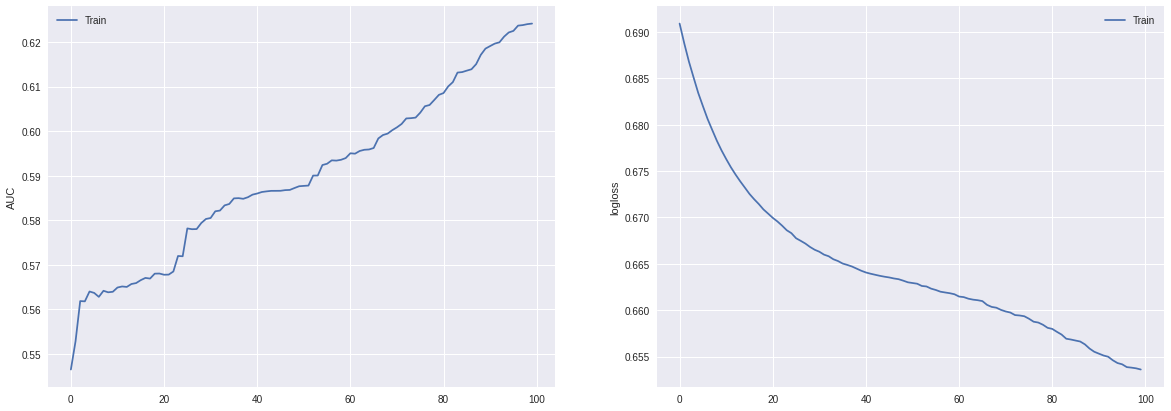

In [40]:
results = model.evals_result()

fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].plot(results['validation_0']['auc'], label='Train')
ax[0].legend(loc='best')
ax[0].set_ylabel('AUC')

ax[1].plot(results['validation_0']['logloss'], label='Train')
ax[1].legend(loc='best')
ax[1].set_ylabel('logloss')


fig.show()

# cross validation for more robust test

In [46]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc
model = XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.05,
    max_depth=6,
    n_estimators=100,
)

scores = cross_val_score(model, X_combined, y_combined, cv=7, scoring='roc_auc')
print(f'{np.mean(scores)} +/- {np.std(scores)}')

0.5879828271873327 +/- 0.0029259321384140827
